<a href="https://colab.research.google.com/github/larasauser/2024_MLEES/blob/main/Project/project_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**# Machine learning Project - Sauser Lara**
## *Filling gaps in NDVI images using CNN*

[Ajouter une image d'illustration]

 [THE CODE IS NOT CLEANED YET]

### 1. Loading the data and separate them into smaller images (32x32 px)
--- This should be done only once per image set because it takes time ---

--- New image set should be used after this step ---



In [14]:
#Dataset stored on Google Drive
from google.colab import drive
drive.mount('/content/drive')


import os
folder_path = '/content/drive/My Drive/NDVI_images/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let's visualise some of our original images.

In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 69.8 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
import rasterio
import numpy as np
# Get a list of files in the directory
tif_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]

# Specify the indices of images you want to display
selected_indices = [10, 45, 90 ]

# Safeguard: Ensure indices are within range
selected_files = [tif_files[i] for i in selected_indices if i < len(tif_files)]

# Set up a GridSpec layout
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, len(selected_files) + 1, width_ratios=[1] * len(selected_files) + [0.1])  # Extra column for the colorbar

axes = [fig.add_subplot(gs[0, i]) for i in range(len(selected_files))]  # Subplots for images
cbar_ax = fig.add_subplot(gs[0, -1])  # Separate subplot for the colorbar

for i, file_name in enumerate(selected_files):
    file_path = os.path.join(folder_path, file_name)

    # Open the GeoTIFF file
    with rasterio.open(file_path) as src:
        ndvi_data = src.read(1)  # Read the first band (NDVI values)
        ndvi_data = np.where(ndvi_data == src.nodata, np.nan, ndvi_data)  # Handle NoData values

    # Plot the NDVI data in the subplot
    im = axes[i].imshow(ndvi_data, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[i].set_title(file_name)
    axes[i].axis('off')

# Add the shared colorbar in the dedicated axis
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('NDVI')

# Adjust layout
plt.tight_layout()
plt.show()

First, we need to fill in the NaN values that come from satellite position. DIRE MIEUX
We use a SimpleImputer based on the median.

In [6]:
import os
import numpy as np
from sklearn.impute import SimpleImputer
import rasterio
# Créer un dossier pour sauvegarder les images corrigées
output_folder = os.path.join(folder_path, "imputed")
os.makedirs(output_folder, exist_ok=True)

# Fonction pour imputer les valeurs NaN
def impute_ndvi_image(image_path, output_path):
    with rasterio.open(image_path) as src:
        image = src.read(1)  # Lecture de la première bande uniquement
        meta = src.meta  # Métadonnées pour sauvegarde

    # Masque des NaN
    nan_mask = np.isnan(image)

    # Imputation des NaN avec la médiane
    imputer = SimpleImputer(strategy='median')
    image_imputed = imputer.fit_transform(image)

    # Sauvegarde de l'image corrigée
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(image_imputed, 1)

# Parcourir toutes les images dans le dossier et appliquer l'imputation
for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):
        input_path = os.path.join(folder_path, filename)
        output_path = os.path.join(output_folder, filename)
        impute_ndvi_image(input_path, output_path)


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]. At least one non-missing value is needed fo

In [7]:
import numpy as np
import os
import rasterio

folder_path = '/content/drive/My Drive/NDVI_images/imputed'

def check_for_nan(image_path):
    with rasterio.open(image_path) as src:
        image = src.read(1)  # Lecture de la première bande

    # Vérifier s'il reste des NaN
    if np.isnan(image).any():
        print(f"Il reste des NaN dans {image_path}")
    else:
        print(f"Pas de NaN dans {image_path}")

# Parcourir toutes les images dans le dossier imputé
for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):
        file_path = os.path.join(folder_path, filename)
        check_for_nan(file_path)


Pas de NaN dans /content/drive/My Drive/NDVI_images/imputed/NDVI_2013-12-30.tif
Pas de NaN dans /content/drive/My Drive/NDVI_images/imputed/NDVI_2014-03-20.tif
Pas de NaN dans /content/drive/My Drive/NDVI_images/imputed/NDVI_2015-04-24.tif
Pas de NaN dans /content/drive/My Drive/NDVI_images/imputed/NDVI_2015-05-10.tif
Pas de NaN dans /content/drive/My Drive/NDVI_images/imputed/NDVI_2020-05-07.tif
Pas de NaN dans /content/drive/My Drive/NDVI_images/imputed/NDVI_2013-07-14(1).tif
Pas de NaN dans /content/drive/My Drive/NDVI_images/imputed/NDVI_2013-08-15(1).tif
Pas de NaN dans /content/drive/My Drive/NDVI_images/imputed/NDVI_2014-07-17(1).tif
Pas de NaN dans /content/drive/My Drive/NDVI_images/imputed/NDVI_2014-07-01.tif
Pas de NaN dans /content/drive/My Drive/NDVI_images/imputed/NDVI_2015-04-15.tif
Pas de NaN dans /content/drive/My Drive/NDVI_images/imputed/NDVI_2015-07-04(1).tif
Pas de NaN dans /content/drive/My Drive/NDVI_images/imputed/NDVI_2015-08-21(1).tif
Pas de NaN dans /content/

To have more images and to reduce computational cost, we decide to devide them into sub-images of 32x32 pixels.

In [8]:
from PIL import Image
import os
def split_image(image_path, output_folder, sub_image_size=(32, 32)):
    # Open image
    img = Image.open(image_path)
    img_width, img_height = img.size

    # Image count
    count = 0

    # Division
    for i in range(0, img_width, sub_image_size[0]):
        for j in range(0, img_height, sub_image_size[1]):
            # Cutting box
            box = (i, j, i + sub_image_size[0], j + sub_image_size[1])
            # Cutting
            sub_image = img.crop(box)
            # Verification (size)
            if sub_image.size[0] > 0 and sub_image.size[1] > 0:
                # Saving
                sub_image.save(os.path.join(output_folder, f"{os.path.splitext(os.path.basename(image_path))[0]}_sub_image_{count}.tif"))
                count += 1
    print(count)

def process_all_images(input_folder, output_folder):
    # List all tif file in input folder
    for filename in os.listdir(input_folder):
        if filename.endswith('.tif'):
            image_path = os.path.join(input_folder, filename)
            print(f"Image in treatment : {filename}")
            split_image(image_path, output_folder)


In [9]:
#Split our images
folder_path = '/content/drive/My Drive/NDVI_images/imputed'
output_folder = '/content/drive/My Drive/NDVI_images/split'
process_all_images(folder_path, output_folder)

Image in treatment : NDVI_2013-12-30.tif
88
Image in treatment : NDVI_2014-03-20.tif
88
Image in treatment : NDVI_2015-04-24.tif
88
Image in treatment : NDVI_2015-05-10.tif
88
Image in treatment : NDVI_2020-05-07.tif
88
Image in treatment : NDVI_2013-07-14(1).tif
88
Image in treatment : NDVI_2013-08-15(1).tif
88
Image in treatment : NDVI_2014-07-17(1).tif
88
Image in treatment : NDVI_2014-07-01.tif
88
Image in treatment : NDVI_2015-04-15.tif
88
Image in treatment : NDVI_2015-07-04(1).tif
88
Image in treatment : NDVI_2015-08-21(1).tif
88
Image in treatment : NDVI_2015-08-05(1).tif
88
Image in treatment : NDVI_2016-08-23(1).tif
88
Image in treatment : NDVI_2016-08-07(1).tif
88
Image in treatment : NDVI_2016-09-08(1).tif
88
Image in treatment : NDVI_2016-09-24(1).tif
88
Image in treatment : NDVI_2017-04-20(1).tif
88
Image in treatment : NDVI_2017-02-15.tif
88
Image in treatment : NDVI_2017-05-22(1).tif
88
Image in treatment : NDVI_2017-08-26(1).tif
88
Image in treatment : NDVI_2017-10-13(

Images are now splitted. We now have 8184 images to use for our model.

### 2. Convolutional Neural Network (CNN)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator



Mounted at /content/drive


In [ ]:
#drive.flush_and_unmount('/content/drive')

Drive not mounted, so nothing to flush and unmount.


#### 2.1 Split the dataset into train, test and validation set

In [11]:
import os
import random
import shutil

In [12]:
# Define the source directory and the new directories for train, validation, and test sets
source_dir = '/content/drive/My Drive/NDVI_images/split'
train_dir = '/content/drive/My Drive/NDVI_images/train'
val_dir = '/content/drive/My Drive/NDVI_images/validation'
test_dir = '/content/drive/My Drive/NDVI_images/test'

In [13]:
# Create the new directories if they don't exist
for dir in [train_dir, val_dir, test_dir]:
    if not os.path.exists(dir):
        os.makedirs(dir)

In [14]:
# Get all image files from the source directory
all_images = [f for f in os.listdir(source_dir) if f.endswith(('.tif'))]

In [15]:
# Shuffle the list of images
random.shuffle(all_images)

In [16]:
len(all_images)

8184

In [17]:
# Calculate the number of images for each set
total_images = len(all_images)
train_split = int(0.7 * total_images)
val_split = int(0.2 * total_images)

In [18]:
# Split the images into train, validation, and test sets
train_images = all_images[:train_split]
val_images = all_images[train_split:train_split+val_split]
test_images = all_images[train_split+val_split:]

In [19]:
# Function to copy images to their respective directories
def copy_images(image_list, destination):
    for image in image_list:
        src = os.path.join(source_dir, image)
        dst = os.path.join(destination, image)
        shutil.copy(src, dst)


In [20]:
# Copy the images to their respective directories
copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

In [21]:
print(f"Total images: {total_images}")
print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")
print(f"Test images: {len(test_images)}")

Total images: 8184
Training images: 5728
Validation images: 1636
Test images: 820


#### 2.2 Create fake holes in images for training set

In [25]:
import os
import numpy as np
import cv2
from tqdm import tqdm

In [26]:
# Define the paths
train_dir = '/content/drive/My Drive/NDVI_images/train'
output_dir = os.path.join(train_dir, 'train_with_holes')

In [27]:
def add_fake_holes(image, num_holes=4, max_hole_size=12):
    """
    Add fake holes to an image to simulate cloud coverage.

    Args:
        image (numpy array): Input image as a NumPy array.
        num_holes (int): Number of fake holes to add.
        max_hole_size (int): Maximum size (in pixels) of each hole.

    Returns:
        numpy array: Image with fake holes applied.
    """
    image_with_holes = image.copy()
    height, width = image.shape[:2]

    for _ in range(num_holes):
        # Randomly select a center for the hole
        x_center = np.random.randint(0, width)
        y_center = np.random.randint(0, height)

        # Randomly determine the size of the hole
        hole_width = np.random.randint(1, max_hole_size)
        hole_height = np.random.randint(1, max_hole_size)

        # Create the hole (set pixel values to zero)
        x_start = max(0, x_center - hole_width // 2)
        x_end = min(width, x_center + hole_width // 2)
        y_start = max(0, y_center - hole_height // 2)
        y_end = min(height, y_center + hole_height // 2)

        image_with_holes[y_start:y_end, x_start:x_end] = np.nan  # Simulate cloud (masked area)

    return image_with_holes


In [28]:
import os
import rasterio
import numpy as np

def process_and_add_fake_holes(train_dir, output_dir):
    """
    Iterate over all GeoTIFF images in a directory, add fake holes, and save the processed images.
    Args:
        train_dir (str): Directory containing input GeoTIFF images.
        output_dir (str): Directory to save processed GeoTIFF images.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate over all images in the train_dir
    for filename in os.listdir(train_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(train_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                # Load the image using rasterio
                with rasterio.open(input_path) as src:
                    image = src.read(1)  # Read the first band
                    meta = src.meta.copy()  # Copy metadata

                # Add fake holes
                image_with_holes = add_fake_holes(image)

                # Update the metadata (e.g., for nodata values)
                meta.update(dtype='float32', nodata=np.nan)

                # Save the processed image
                with rasterio.open(output_path, 'w', **meta) as dst:
                    dst.write(image_with_holes, 1)  # Write to the first band

                #print(f"Processed and saved: {output_path}")

            except Exception as e:
                print(f"Failed to process {filename}: {e}")


In [29]:
process_and_add_fake_holes(train_dir, output_dir)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


#### 2.3 Create holes in image of the validation set

In [1]:
import os
import numpy as np
import cv2
from tqdm import tqdm

In [3]:
# Define the paths
val_dir = '/content/drive/My Drive/NDVI_images/validation'
output_dir = os.path.join(val_dir, 'val_with_holes')

In [4]:
# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

In [8]:
def add_fake_holes(image, num_holes=4, max_hole_size=12):
    """
    Add fake holes to an image to simulate cloud coverage.

    Args:
        image (numpy array): Input image as a NumPy array.
        num_holes (int): Number of fake holes to add.
        max_hole_size (int): Maximum size (in pixels) of each hole.

    Returns:
        numpy array: Image with fake holes applied.
    """
    image_with_holes = image.copy()
    height, width = image.shape[:2]

    for _ in range(num_holes):
        # Randomly select a center for the hole
        x_center = np.random.randint(0, width)
        y_center = np.random.randint(0, height)

        # Randomly determine the size of the hole
        hole_width = np.random.randint(1, max_hole_size)
        hole_height = np.random.randint(1, max_hole_size)

        # Create the hole (set pixel values to zero)
        x_start = max(0, x_center - hole_width // 2)
        x_end = min(width, x_center + hole_width // 2)
        y_start = max(0, y_center - hole_height // 2)
        y_end = min(height, y_center + hole_height // 2)

        image_with_holes[y_start:y_end, x_start:x_end] = np.nan  # Simulate cloud (masked area)

    return image_with_holes


In [9]:
import os
import rasterio
import numpy as np

def process_and_add_fake_holes(val_dir, output_dir):
    """
    Iterate over all GeoTIFF images in a directory, add fake holes, and save the processed images.
    Args:
        train_dir (str): Directory containing input GeoTIFF images.
        output_dir (str): Directory to save processed GeoTIFF images.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate over all images in the train_dir
    for filename in os.listdir(val_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(val_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                # Load the image using rasterio
                with rasterio.open(input_path) as src:
                    image = src.read(1)  # Read the first band
                    meta = src.meta.copy()  # Copy metadata

                # Add fake holes
                image_with_holes = add_fake_holes(image)

                # Update the metadata (e.g., for nodata values)
                meta.update(dtype='float32', nodata=np.nan)

                # Save the processed image
                with rasterio.open(output_path, 'w', **meta) as dst:
                    dst.write(image_with_holes, 1)  # Write to the first band

                #print(f"Processed and saved: {output_path}")

            except Exception as e:
                print(f"Failed to process {filename}: {e}")


In [10]:
process_and_add_fake_holes(val_dir, output_dir)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


#### 2.4 Building the CNN

In [6]:
#Load the training data
from google.colab import drive
drive.mount('/content/drive')

train_dir = '/content/drive/My Drive/NDVI_images/train'
train_with_holes_dir = '/content/drive/My Drive/NDVI_images/train/train_with_holes'

val_dir = '/content/drive/My Drive/NDVI_images/validation'
val_with_holes_dir = '/content/drive/My Drive/NDVI_images/validation/val_with_holes'

Mounted at /content/drive


In [11]:
#Dependencies
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
!pip install rasterio
import rasterio
import os
import cv2
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from PIL import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 31.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


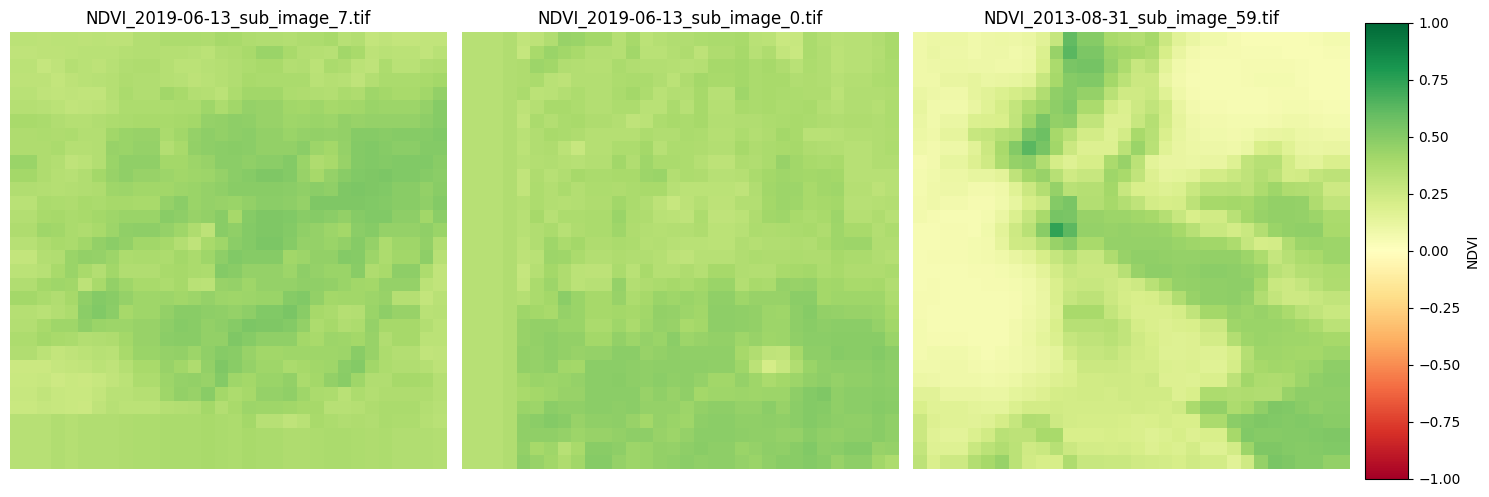

In [13]:
# Get a list of files in the directory
tif_files = [f for f in os.listdir(train_dir) if f.endswith('.tif')]

# Specify the indices of images you want to display
selected_indices = [0, 5, 500 ]

# Safeguard: Ensure indices are within range
selected_files = [tif_files[i] for i in selected_indices if i < len(tif_files)]

# Set up a GridSpec layout
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, len(selected_files) + 1, width_ratios=[1] * len(selected_files) + [0.1])  # Extra column for the colorbar

axes = [fig.add_subplot(gs[0, i]) for i in range(len(selected_files))]  # Subplots for images
cbar_ax = fig.add_subplot(gs[0, -1])  # Separate subplot for the colorbar

for i, file_name in enumerate(selected_files):
    file_path = os.path.join(train_dir, file_name)

    # Open the GeoTIFF file
    with rasterio.open(file_path) as src:
        ndvi_data = src.read(1)  # Read the first band (NDVI values)
        ndvi_data = np.where(ndvi_data == src.nodata, np.nan, ndvi_data)  # Handle NoData values

    # Plot the NDVI data in the subplot
    im = axes[i].imshow(ndvi_data, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[i].set_title(file_name)
    axes[i].axis('off')

# Add the shared colorbar in the dedicated axis
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('NDVI')

# Adjust layout
plt.tight_layout()
plt.show()


In [14]:
# Get a list of all files in the directory
file_list = os.listdir(train_dir)

# Get the number of files
num_files = len(file_list)

# Print the number of files
print(f"There are {num_files} files in the directory.")

There are 5729 files in the directory.


In [15]:
# Get a list of all files in the directory
file_list = os.listdir(train_with_holes_dir)

# Get the number of files
num_files = len(file_list)

# Print the number of files
print(f"There are {num_files} files in the directory.")

There are 5728 files in the directory.


In [16]:
# Get a list of all files in the directory
file_list = os.listdir(val_dir)

# Get the number of files
num_files = len(file_list)

# Print the number of files
print(f"There are {num_files} files in the directory.")

There are 1637 files in the directory.


In [17]:
# Get a list of all files in the directory
file_list = os.listdir(val_with_holes_dir)

# Get the number of files
num_files = len(file_list)

# Print the number of files
print(f"There are {num_files} files in the directory.")

There are 1636 files in the directory.


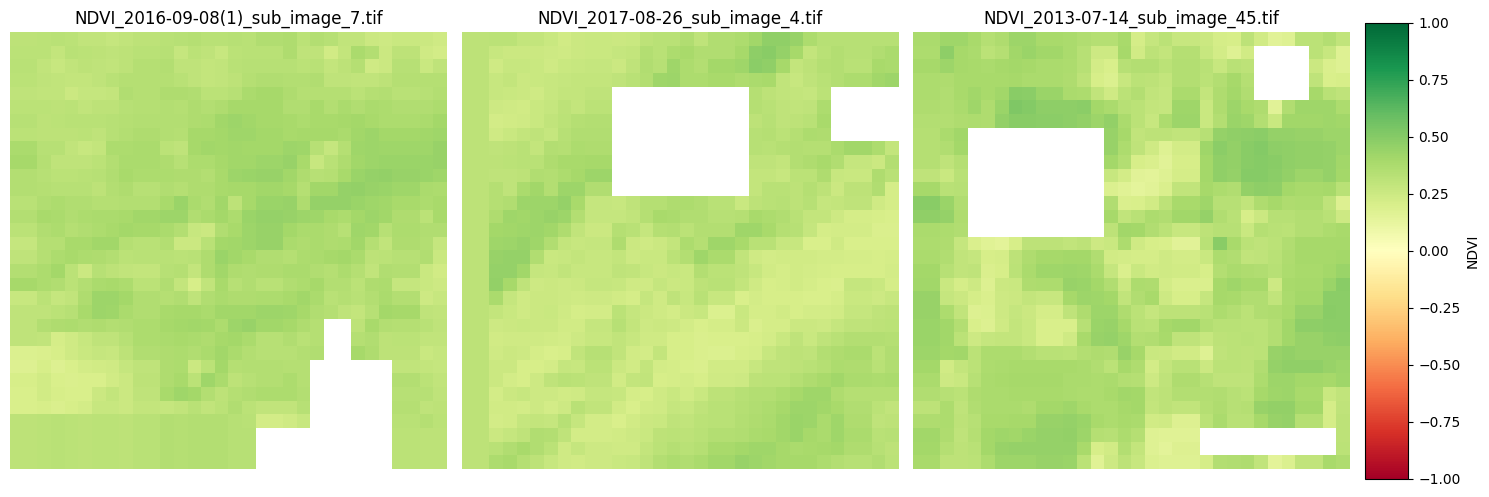

In [18]:
# Get a list of files in the directory
tif_files = [f for f in os.listdir(train_with_holes_dir) if f.endswith('.tif')]

# Specify the indices of images you want to display
selected_indices = [0, 50, 1000 ]

# Safeguard: Ensure indices are within range
selected_files = [tif_files[i] for i in selected_indices if i < len(tif_files)]

# Set up a GridSpec layout
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, len(selected_files) + 1, width_ratios=[1] * len(selected_files) + [0.1])  # Extra column for the colorbar

axes = [fig.add_subplot(gs[0, i]) for i in range(len(selected_files))]  # Subplots for images
cbar_ax = fig.add_subplot(gs[0, -1])  # Separate subplot for the colorbar

for i, file_name in enumerate(selected_files):
    file_path = os.path.join(train_with_holes_dir, file_name)

    # Open the GeoTIFF file
    with rasterio.open(file_path) as src:
        ndvi_data = src.read(1)  # Read the first band (NDVI values)
        ndvi_data = np.where(ndvi_data == src.nodata, np.nan, ndvi_data)  # Handle NoData values

    # Plot the NDVI data in the subplot
    im = axes[i].imshow(ndvi_data, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[i].set_title(file_name)
    axes[i].axis('off')

# Add the shared colorbar in the dedicated axis
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('NDVI')

# Adjust layout
plt.tight_layout()
plt.show()

##### 2.4.1 Pairing the complete images with the images with holes (train and validation)

In [12]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
!pip install keras-tuner
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.1 MB/s eta 0:00:00


In [13]:
def load_and_pair_images(input_dir, target_dir):
    """Load original images and images with holes, and pair them."""
    image_pairs = []
    for filename in os.listdir(input_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(input_dir, filename)
            target_path = os.path.join(target_dir, filename)

            # Load images
            input_img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
            target_img = cv2.imread(target_path, cv2.IMREAD_UNCHANGED)

            if input_img is not None and target_img is not None:
                image_pairs.append((input_img, target_img))
            else:
                print(f"Failed to load {filename}. Skipping...")
    return image_pairs

In [14]:
# Load and pair the training data
train_data = load_and_pair_images(train_dir, train_with_holes_dir)

# Load and pair validation images with holes
val_data = load_and_pair_images(val_dir, val_with_holes_dir)

##### 2.4.2 Data processing and masking

In [15]:
MASK_VALUE = 10  # Set a value to replace NaN

In [16]:
# Convert to numpy arrays
X_train = np.array([pair[0] for pair in train_data])
y_train = np.array([pair[1] for pair in train_data])

In [17]:
X_val = np.array([pair[0] for pair in val_data])
y_val = np.array([pair[1] for pair in val_data])

In [18]:
# Replace NaN with MASK_VALUE in training and validation datasets
X_train = np.nan_to_num(X_train, nan=MASK_VALUE)
y_train = np.nan_to_num(y_train, nan=MASK_VALUE)

X_val = np.nan_to_num(X_val, nan=MASK_VALUE)
y_val = np.nan_to_num(y_val, nan=MASK_VALUE)


In [19]:
print("X_train min, max:", np.min(X_train), np.max(X_train))
print("y_train min, max:", np.min(y_train), np.max(y_train))
print("X_val min, max:", np.min(X_val), np.max(X_val))
print("y_val min, max:", np.min(y_val), np.max(y_val))

X_train min, max: -0.12699474 0.9998047
y_train min, max: -0.12699474 10.0
X_val min, max: -0.1493801 0.9994043
y_val min, max: -0.1493801 10.0


In [20]:
# Define the custom loss function
def masked_mae(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, MASK_VALUE), tf.float32)
    loss = tf.reduce_sum(mask * tf.abs(y_true - y_pred)) / tf.reduce_sum(mask)
    return loss

##### 2.4.3 Building the U-Net CNN Model for Image Inpainting

In [2]:
from tensorflow.keras import layers, models

In [3]:
def build_unet_model(input_shape):
    """Build a simple U-Net model."""
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    # Bottleneck
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)

    # Decoder
    up3 = layers.UpSampling2D((2, 2))(conv2)
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up3)

    # Output layer
    output = layers.Conv2D(1, (1, 1), activation='tanh', padding='same')(conv3)

    # Compile model
    model = models.Model(inputs, output)
    model.compile(optimizer='adam', loss=masked_mae, metrics=['mae'])

    return model

##### 2.4.4 Hyperparameter optimization using Keras tuner

In [4]:
def model_builder(hp):
    """Build a U-Net model with hyperparameter tuning."""
    model = build_unet_model((32, 32, 1))

    # Tune the learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
    ), loss=masked_mae, metrics=['mae'])

    return model

In [16]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=10,  # Limit to 10 trials
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='ndvi_inpainting',
)

In [18]:
# Perform Hyperparameter Search
tuner.search(X_train, y_train, epochs=4, validation_data=(X_val, y_val),
            batch_size=32)

Trial 10 Complete [00h 13m 04s]
val_loss: 0.013840405270457268

Best val_loss So Far: 0.008480638265609741
Total elapsed time: 02h 24m 05s


In [19]:
# Get the best Hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best learning rate: ", best_hp['learning_rate'])

Best learning rate:  0.0006130578503627999


In [20]:
import json

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Save the hyperparameters to a JSON file
hyperparameters_path = '/content/drive/My Drive/NDVI_images/best_hyperparameters_1.json'

with open(hyperparameters_path, 'w') as f:
    json.dump(best_hp.values, f, indent=4)

print(f"Best hyperparameters saved to {hyperparameters_path}")


Best hyperparameters saved to /content/drive/My Drive/NDVI_images/best_hyperparameters_1.json


##### 2.4.5 Train the model with the best Hyperparameters

In [ ]:
best_hp = 0.0008506876632789835

In [7]:
import json
hyperparameters_path = '/content/drive/My Drive/NDVI_images/best_hyperparameters_1.json'
# Load the hyperparameters from the JSON file
with open(hyperparameters_path, 'r') as f:
    loaded_hyperparameters = json.load(f)

print("Loaded hyperparameters:", loaded_hyperparameters)

Loaded hyperparameters: {'learning_rate': 0.0006130578503627999}


In [8]:
from tensorflow.keras.optimizers import Adam
# Rebuild the U-Net model
input_shape = (32, 32, 1)  # Adjust as per your dataset
best_model = build_unet_model(input_shape)

# Compile the model with the loaded learning rate
best_model.compile(
    optimizer=Adam(learning_rate=loaded_hyperparameters['learning_rate']),
    loss=masked_mae,
    metrics=['mae']
)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
# Configure EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=3,               # Stop training if no improvement after 3 epochs
    restore_best_weights=True # Restore model weights from the best epoch
)

In [21]:
#best_model = tuner.hypermodel.build(best_hp)

# Set up callbacks to monitor progress
history = best_model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), batch_size=16,callbacks=[early_stopping])


Epoch 1/25
358/358 ━━━━━━━━━━━━━━━━━━━━ 173s 467ms/step - loss: 0.0441 - mae: 1.0084 - val_loss: 0.0119 - val_mae: 0.9771
Epoch 2/25
358/358 ━━━━━━━━━━━━━━━━━━━━ 204s 474ms/step - loss: 0.0123 - mae: 0.9743 - val_loss: 0.0102 - val_mae: 0.9756
Epoch 3/25
358/358 ━━━━━━━━━━━━━━━━━━━━ 208s 491ms/step - loss: 0.0095 - mae: 0.9669 - val_loss: 0.0121 - val_mae: 0.9769
Epoch 4/25
358/358 ━━━━━━━━━━━━━━━━━━━━ 193s 467ms/step - loss: 0.0085 - mae: 0.9764 - val_loss: 0.0076 - val_mae: 0.9740
Epoch 5/25
358/358 ━━━━━━━━━━━━━━━━━━━━ 201s 464ms/step - loss: 0.0075 - mae: 0.9668 - val_loss: 0.0092 - val_mae: 0.9745
Epoch 6/25
358/358 ━━━━━━━━━━━━━━━━━━━━ 207s 478ms/step - loss: 0.0083 - mae: 0.9709 - val_loss: 0.0064 - val_mae: 0.9730
Epoch 7/25
358/358 ━━━━━━━━━━━━━━━━━━━━ 197s 464ms/step - loss: 0.0072 - mae: 0.9699 - val_loss: 0.0095 - val_mae: 0.9762
Epoch 8/25
358/358 ━━━━━━━━━━━━━━━━━━━━ 213s 495ms/step - loss: 0.0070 - mae: 0.9643 - val_loss: 0.0066 - val_mae: 0.9732
Epoch 9/25
358/358 ━━━━━

In [22]:
# Save the model
best_model.save('/content/drive/My Drive/NDVI_images/best_unet_model_1.keras')

##### 2.4.6 Loss and Accuracy Graphs

In [23]:
def plot_history(history, save_path):
    """Plot loss and MAE over epochs and save the plots."""
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot MAE (Mean Absolute Error)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Mean Absolute Error (MAE)')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    # Save the plots to file
    plt.savefig(save_path)
    plt.close()

In [24]:
plot_history(history, '/content/drive/My Drive/NDVI_images/training_history_1.png')

##### 2.5 Verification on the Test set

##### 2.5.1 Create fake holes in images for test set

In [21]:
import os
import numpy as np
import cv2
from tqdm import tqdm

In [46]:
# Define the paths
test_dir = '/content/drive/My Drive/NDVI_images/test'
output_dir = os.path.join(test_dir, 'test_with_holes')

In [23]:
# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

In [24]:
def add_fake_holes(image, num_holes=4, max_hole_size=12):
    """
    Add fake holes to an image to simulate cloud coverage.

    Args:
        image (numpy array): Input image as a NumPy array.
        num_holes (int): Number of fake holes to add.
        max_hole_size (int): Maximum size (in pixels) of each hole.

    Returns:
        numpy array: Image with fake holes applied.
    """
    image_with_holes = image.copy()
    height, width = image.shape[:2]

    for _ in range(num_holes):
        # Randomly select a center for the hole
        x_center = np.random.randint(0, width)
        y_center = np.random.randint(0, height)

        # Randomly determine the size of the hole
        hole_width = np.random.randint(1, max_hole_size)
        hole_height = np.random.randint(1, max_hole_size)

        # Create the hole (set pixel values to zero)
        x_start = max(0, x_center - hole_width // 2)
        x_end = min(width, x_center + hole_width // 2)
        y_start = max(0, y_center - hole_height // 2)
        y_end = min(height, y_center + hole_height // 2)

        image_with_holes[y_start:y_end, x_start:x_end] = np.nan  # Simulate cloud (masked area)

    return image_with_holes


In [25]:
import os
!pip install rasterio
import rasterio
import numpy as np

def process_and_add_fake_holes(test_dir, output_dir):
    """
    Iterate over all GeoTIFF images in a directory, add fake holes, and save the processed images.
    Args:
        train_dir (str): Directory containing input GeoTIFF images.
        output_dir (str): Directory to save processed GeoTIFF images.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate over all images in the train_dir
    for filename in os.listdir(test_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(test_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                # Load the image using rasterio
                with rasterio.open(input_path) as src:
                    image = src.read(1)  # Read the first band
                    meta = src.meta.copy()  # Copy metadata

                # Add fake holes
                image_with_holes = add_fake_holes(image)

                # Update the metadata (e.g., for nodata values)
                meta.update(dtype='float32', nodata=np.nan)

                # Save the processed image
                with rasterio.open(output_path, 'w', **meta) as dst:
                    dst.write(image_with_holes, 1)  # Write to the first band

                #print(f"Processed and saved: {output_path}")

            except Exception as e:
                print(f"Failed to process {filename}: {e}")


In [26]:
process_and_add_fake_holes(test_dir, output_dir)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


In [25]:
#Load the test data
from google.colab import drive
drive.mount('/content/drive')

test_dir = '/content/drive/My Drive/NDVI_images/test'
test_with_holes_dir = '/content/drive/My Drive/NDVI_images/test/test_with_holes'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### 2.5.2 Pairing the complete images with the images with holes (test)

In [26]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
!pip install keras-tuner
import keras_tuner as kt

In [27]:
def load_and_pair_images(input_dir, target_dir):
    """Load original images and images with holes, and pair them."""
    image_pairs = []
    for filename in os.listdir(input_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(input_dir, filename)
            target_path = os.path.join(target_dir, filename)

            # Load images
            input_img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
            target_img = cv2.imread(target_path, cv2.IMREAD_UNCHANGED)

            if input_img is not None and target_img is not None:
                image_pairs.append((input_img, target_img))
            else:
                print(f"Failed to load {filename}. Skipping...")
    return image_pairs

In [28]:
# Load and pair the training data
test_data = load_and_pair_images(test_dir, test_with_holes_dir)

##### 2.5.3 Data processing and masking

In [29]:
MASK_VALUE = 10  # Set a value to replace NaN

In [30]:
# Convert to numpy arrays
X_test = np.array([pair[0] for pair in test_data])
y_test = np.array([pair[1] for pair in test_data])

In [31]:
# Replace NaN with MASK_VALUE in training and validation datasets
X_test = np.nan_to_num(X_test, nan=MASK_VALUE)
y_test = np.nan_to_num(y_test, nan=MASK_VALUE)

In [32]:
print("X_test min, max:", np.min(X_test), np.max(X_test))
print("y_test min, max:", np.min(y_test), np.max(y_test))

X_test min, max: -0.09456226 0.9920558
y_test min, max: -0.09456226 10.0


In [33]:
# Define the custom loss function
def masked_mae(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, MASK_VALUE), tf.float32)
    loss = tf.reduce_sum(mask * tf.abs(y_true - y_pred)) / tf.reduce_sum(mask)
    return loss

##### 2.5.4 Apply CNN

In [35]:
from tensorflow.keras.models import load_model
#Load the training data
from google.colab import drive
drive.mount('/content/drive')

# Load the saved model
model_path = '/content/drive/My Drive/NDVI_images/best_unet_model_1.keras'
best_model = load_model(model_path, custom_objects={'masked_mae': masked_mae})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# Evaluate the model
test_loss, test_mae = best_model.evaluate(X_test, y_test, batch_size=32)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 445ms/step - loss: 0.0036 - mae: 0.9478
Test Loss: 0.003591723507270217
Test MAE: 0.954818844795227


In [37]:
# Generate predictions
y_pred = best_model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step


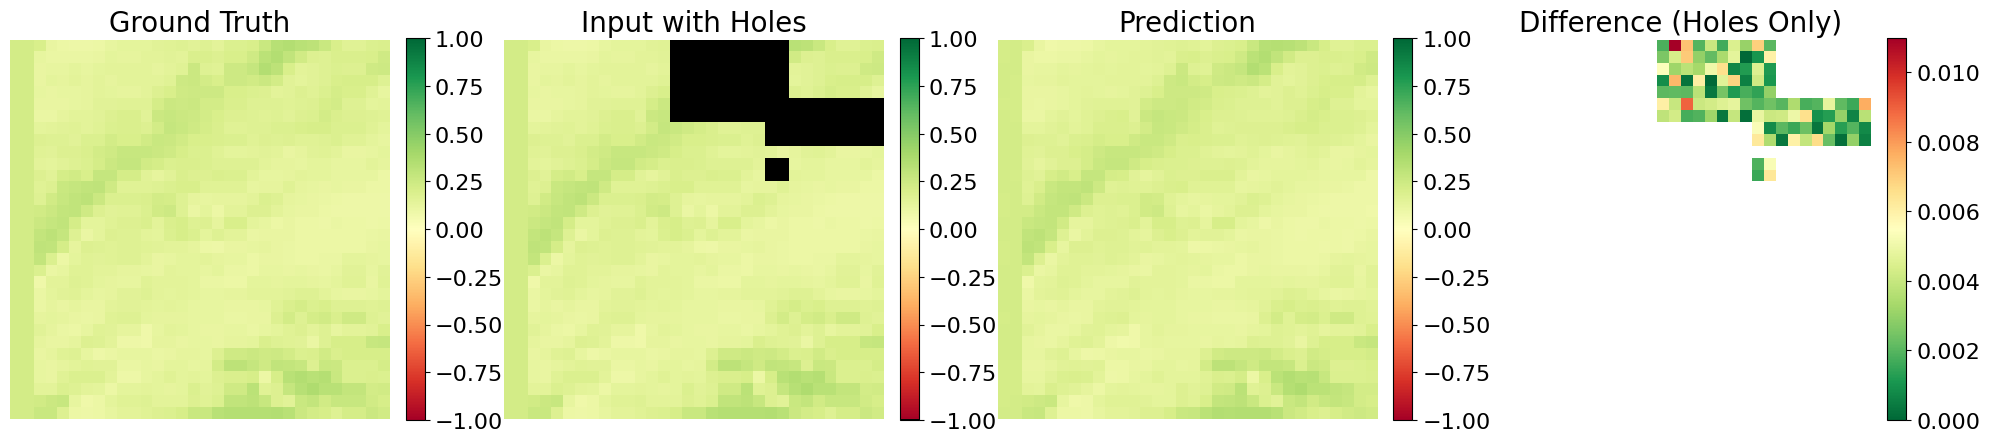

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, ListedColormap

# Création d'une colormap personnalisée pour les trous (valeurs spéciales = 10)
cmap = plt.cm.RdYlGn  # Colormap de base
cmap_colors = cmap(np.linspace(0, 1, 256))
cmap_colors[0] = [0, 0, 0, 1]  # Noir pour les trous (valeurs à 10)
custom_cmap = ListedColormap(cmap_colors)

# Normalisation personnalisée
class CustomNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, special_value=None, **kwargs):
        super().__init__(vmin=vmin, vmax=vmax, **kwargs)
        self.special_value = special_value

    def __call__(self, value, clip=None):
        # Traite les trous comme une valeur spéciale
        result = super().__call__(value, clip)
        result = np.ma.masked_where(value == self.special_value, result)
        result = np.ma.filled(result, 0)  # Mappe les trous (valeurs à 10) sur la première couleur (noir)
        return result

# Appliquer la normalisation personnalisée pour gérer les trous
norm = CustomNormalize(vmin=-1, vmax=1, special_value=10)

# Calcul de la différence entre l'image prédite et l'image originale
difference = np.abs(X_test - y_pred.squeeze())  # Différence absolue

# Créer un masque pour afficher uniquement les trous
mask_holes = (y_test == 10)  # Masque des pixels troués
difference_holes_only = np.where(mask_holes, difference, np.nan)  # Masque les autres pixels

# Visualisation des résultats
idx = 555  # Index pour visualiser un échantillon spécifique

plt.figure(figsize=(20, 5))

# Vérité terrain
plt.subplot(1, 4, 1)
plt.title("Ground Truth", fontsize=20)  # Increase font size
img1 = plt.imshow(X_test[idx, :, :], cmap='RdYlGn', norm=norm)
plt.axis('off')
cbar1 = plt.colorbar(img1, fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=16)  # Increase colorbar font size

# Image d'entrée avec trous
plt.subplot(1, 4, 2)
plt.title("Input with Holes", fontsize=20)  # Increase font size
img2 = plt.imshow(y_test[idx, :, :], cmap=custom_cmap, norm=norm)
plt.axis('off')
cbar2 = plt.colorbar(img2, fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=16)  # Increase colorbar font size

# Prédictions
plt.subplot(1, 4, 3)
plt.title("Prediction", fontsize=20)  # Increase font size
img3 = plt.imshow(y_pred[idx, :, :], cmap='RdYlGn', norm=norm)
plt.axis('off')
cbar3 = plt.colorbar(img3, fraction=0.046, pad=0.04)
cbar3.ax.tick_params(labelsize=16)  # Increase colorbar font size

# Différence uniquement dans les trous
plt.subplot(1, 4, 4)
plt.title("Difference (Holes Only)", fontsize=20)  # Increase font size
img4 = plt.imshow(difference_holes_only[idx, :, :], cmap='RdYlGn_r', vmin=0)  # Colormap pour différences
plt.axis('off')
cbar4 = plt.colorbar(img4, fraction=0.046, pad=0.04)
cbar4.ax.tick_params(labelsize=16)  # Increase colorbar font size

plt.tight_layout()
plt.show()


##### 2.5.5 Evaluate the model

In [39]:
import numpy as np

# Example: Assuming `MASK_VALUE` is the value used for invalid pixels
MASK_VALUE = 10  # Replace with your actual mask value

# Flatten the arrays to simplify processing (if needed)
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Step 1: Create a mask for valid pixels
valid_mask = y_test_flat != MASK_VALUE

# Step 2: Extract valid pixels from ground truth and predictions
y_test_valid = y_test_flat[valid_mask]
y_pred_valid = y_pred_flat[valid_mask]

# Step 3: Evaluate the model using the valid pixels
# Example: Calculate RMSE
rmse = np.sqrt(np.mean((y_test_valid - y_pred_valid) ** 2))
print(f"RMSE: {rmse}")

# Example: Calculate correlation coefficient (R²)
correlation = np.corrcoef(y_test_valid, y_pred_valid)[0, 1]
r_squared = correlation ** 2
print(f"R²: {r_squared}")



RMSE: 0.005393275059759617
R²: 0.9985863348143312


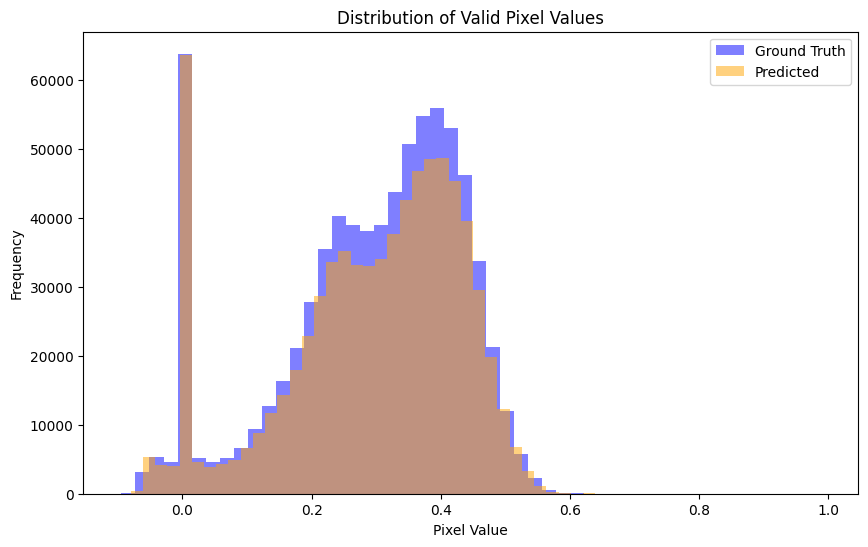

<ipython-input-40-ebc25c7733d0>:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test_valid, label='Ground Truth', color='blue', shade=True)
<ipython-input-40-ebc25c7733d0>:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_valid, label='Predicted', color='orange', shade=True)


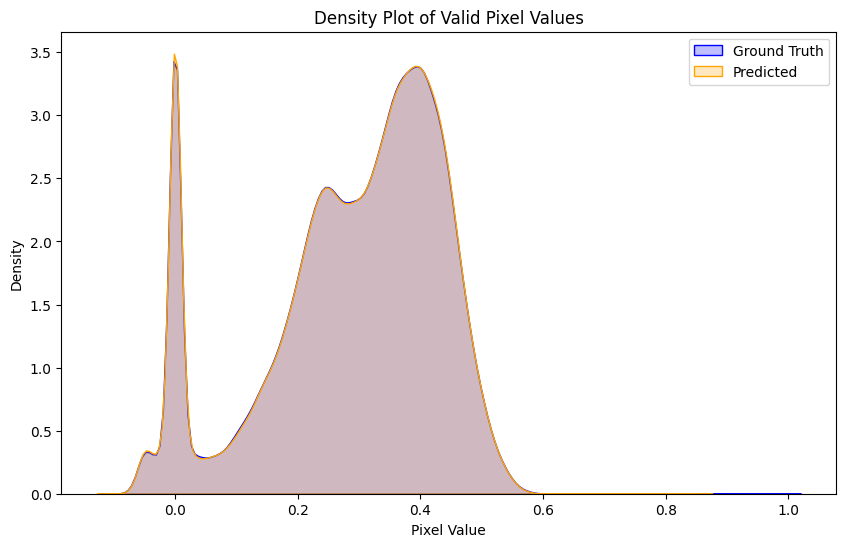

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(y_test_valid, bins=50, alpha=0.5, label='Ground Truth', color='blue')
plt.hist(y_pred_valid, bins=50, alpha=0.5, label='Predicted', color='orange')
plt.title('Distribution of Valid Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Optional: Density plot (smoother)
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test_valid, label='Ground Truth', color='blue', shade=True)
sns.kdeplot(y_pred_valid, label='Predicted', color='orange', shade=True)
plt.title('Density Plot of Valid Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.legend()
plt.show()


In [41]:
mae = np.mean(np.abs(y_test_valid - y_pred_valid))
print(f"Mean Absolute Error (MAE): {mae}")
rmse = np.sqrt(np.mean((y_test_valid - y_pred_valid) ** 2))
print(f"Root Mean Square Error (RMSE): {rmse}")
mape = np.mean(np.abs((y_test_valid - y_pred_valid) / y_test_valid)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
correlation = np.corrcoef(y_test_valid, y_pred_valid)[0, 1]
r_squared = correlation ** 2
print(f"R² (Coefficient of Determination): {r_squared}")


Mean Absolute Error (MAE): 0.0035899390932172537
Root Mean Square Error (RMSE): 0.005393275059759617
Mean Absolute Percentage Error (MAPE): inf%
R² (Coefficient of Determination): 0.9985863348143312


<ipython-input-41-f0cdbcfc372e>:5: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test_valid - y_pred_valid) / y_test_valid)) * 100


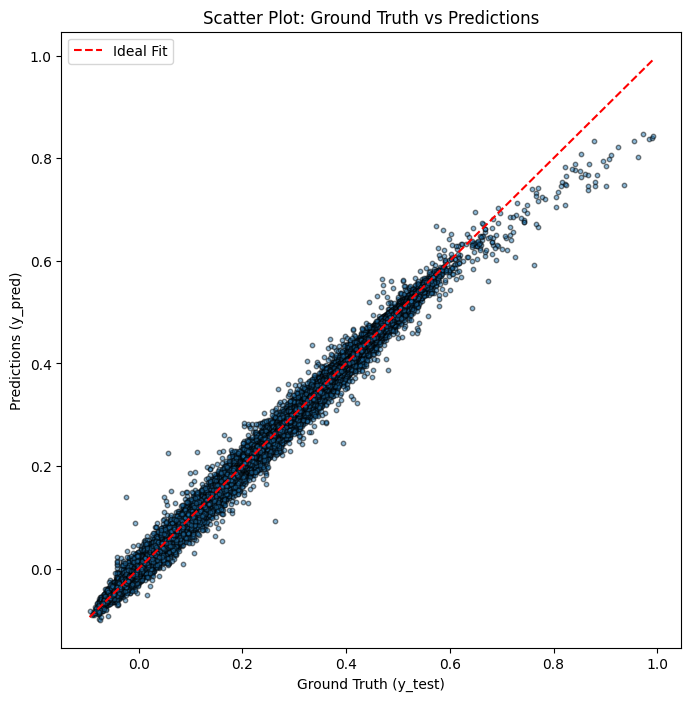

In [43]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test_valid, y_pred_valid, alpha=0.5, edgecolor='k', s=10)
plt.plot([y_test_valid.min(), y_test_valid.max()],
         [y_test_valid.min(), y_test_valid.max()],
         color='red', linestyle='--', label='Ideal Fit')
plt.title('Scatter Plot: Ground Truth vs Predictions')
plt.xlabel('Ground Truth (y_test)')
plt.ylabel('Predictions (y_pred)')
plt.legend()
plt.show()


#### 3. Test on another region (Val d'Hérens)

In [1]:
import os
import numpy as np
import cv2
from tqdm import tqdm

In [2]:
#Dataset stored on Google Drive
from google.colab import drive
drive.mount('/content/drive')


import os
folder_path = '/content/drive/My Drive/NDVI_herens/'

Mounted at /content/drive


In [3]:
import os
import numpy as np
from sklearn.impute import SimpleImputer
!pip install rasterio
import rasterio
# Créer un dossier pour sauvegarder les images corrigées
output_folder = os.path.join(folder_path, "imputed")
os.makedirs(output_folder, exist_ok=True)

# Fonction pour imputer les valeurs NaN
def impute_ndvi_image(image_path, output_path):
    with rasterio.open(image_path) as src:
        image = src.read(1)  # Lecture de la première bande uniquement
        meta = src.meta  # Métadonnées pour sauvegarde

    # Masque des NaN
    nan_mask = np.isnan(image)

    # Imputation des NaN avec la médiane
    imputer = SimpleImputer(strategy='median')
    image_imputed = imputer.fit_transform(image)

    # Sauvegarde de l'image corrigée
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(image_imputed, 1)

# Parcourir toutes les images dans le dossier et appliquer l'imputation
for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):
        input_path = os.path.join(folder_path, filename)
        output_path = os.path.join(output_folder, filename)
        impute_ndvi_image(input_path, output_path)


KeyboardInterrupt: 

In [4]:
import numpy as np
import os
import rasterio

folder_path = '/content/drive/My Drive/NDVI_herens/imputed'

def check_for_nan(image_path):
    with rasterio.open(image_path) as src:
        image = src.read(1)  # Lecture de la première bande

    # Vérifier s'il reste des NaN
    if np.isnan(image).any():
        print(f"Il reste des NaN dans {image_path}")
    else:
        print(f"Pas de NaN dans {image_path}")

# Parcourir toutes les images dans le dossier imputé
for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):
        file_path = os.path.join(folder_path, filename)
        check_for_nan(file_path)

Pas de NaN dans /content/drive/My Drive/NDVI_herens/imputed/NDVI_Val_Herens_2013-04-18.tif
Pas de NaN dans /content/drive/My Drive/NDVI_herens/imputed/NDVI_Val_Herens_2013-11-12.tif
Pas de NaN dans /content/drive/My Drive/NDVI_herens/imputed/NDVI_Val_Herens_2013-12-30.tif
Pas de NaN dans /content/drive/My Drive/NDVI_herens/imputed/NDVI_Val_Herens_2013-11-28.tif
Pas de NaN dans /content/drive/My Drive/NDVI_herens/imputed/NDVI_Val_Herens_2014-03-20.tif
Pas de NaN dans /content/drive/My Drive/NDVI_herens/imputed/NDVI_Val_Herens_2014-06-08.tif
Pas de NaN dans /content/drive/My Drive/NDVI_herens/imputed/NDVI_Val_Herens_2014-10-30.tif
Pas de NaN dans /content/drive/My Drive/NDVI_herens/imputed/NDVI_Val_Herens_2015-02-19.tif
Pas de NaN dans /content/drive/My Drive/NDVI_herens/imputed/NDVI_Val_Herens_2015-04-24.tif
Pas de NaN dans /content/drive/My Drive/NDVI_herens/imputed/NDVI_Val_Herens_2015-04-08.tif
Pas de NaN dans /content/drive/My Drive/NDVI_herens/imputed/NDVI_Val_Herens_2015-08-30.tif

In [3]:
from PIL import Image
import os
def split_image(image_path, output_folder, sub_image_size=(32, 32)):
    # Open image
    img = Image.open(image_path)
    img_width, img_height = img.size

    # Image count
    count = 0

    # Division
    for i in range(0, img_width, sub_image_size[0]):
        for j in range(0, img_height, sub_image_size[1]):
            # Cutting box
            box = (i, j, i + sub_image_size[0], j + sub_image_size[1])
            # Cutting
            sub_image = img.crop(box)
            # Verification (size)
            if sub_image.size[0] > 0 and sub_image.size[1] > 0:
                # Saving
                sub_image.save(os.path.join(output_folder, f"{os.path.splitext(os.path.basename(image_path))[0]}_sub_image_{count}.tif"))
                count += 1
    print(count)

def process_all_images(input_folder, output_folder):
    # List all tif file in input folder
    for filename in os.listdir(input_folder):
        if filename.endswith('.tif'):
            image_path = os.path.join(input_folder, filename)
            print(f"Image in treatment : {filename}")
            split_image(image_path, output_folder)


In [4]:
#Split our images
folder_path = '/content/drive/My Drive/NDVI_herens/imputed'
output_folder = '/content/drive/My Drive/NDVI_herens/split'
process_all_images(folder_path, output_folder)

Image in treatment : NDVI_Val_Herens_2015-02-19.tif
600
Image in treatment : NDVI_Val_Herens_2015-08-30.tif
600
Image in treatment : NDVI_Val_Herens_2016-12-06.tif
600
Image in treatment : NDVI_Val_Herens_2017-04-29.tif
600
Image in treatment : NDVI_Val_Herens_2019-01-29.tif
600
Image in treatment : NDVI_Val_Herens_2020-01-16.tif
600
Image in treatment : NDVI_Val_Herens_2021-03-23.tif
600
Image in treatment : NDVI_Val_Herens_2022-01-21.tif
600
Image in treatment : NDVI_Val_Herens_2022-07-16.tif
600
Image in treatment : NDVI_Val_Herens_2023-08-20.tif
600


In [8]:
# Define the paths
test_dir = '/content/drive/My Drive/NDVI_herens/split'
output_dir = os.path.join(test_dir, 'herens_with_holes')

In [9]:
# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

In [10]:
def add_fake_holes(image, num_holes=4, max_hole_size=12):
    """
    Add fake holes to an image to simulate cloud coverage.

    Args:
        image (numpy array): Input image as a NumPy array.
        num_holes (int): Number of fake holes to add.
        max_hole_size (int): Maximum size (in pixels) of each hole.

    Returns:
        numpy array: Image with fake holes applied.
    """
    image_with_holes = image.copy()
    height, width = image.shape[:2]

    for _ in range(num_holes):
        # Randomly select a center for the hole
        x_center = np.random.randint(0, width)
        y_center = np.random.randint(0, height)

        # Randomly determine the size of the hole
        hole_width = np.random.randint(1, max_hole_size)
        hole_height = np.random.randint(1, max_hole_size)

        # Create the hole (set pixel values to zero)
        x_start = max(0, x_center - hole_width // 2)
        x_end = min(width, x_center + hole_width // 2)
        y_start = max(0, y_center - hole_height // 2)
        y_end = min(height, y_center + hole_height // 2)

        image_with_holes[y_start:y_end, x_start:x_end] = np.nan  # Simulate cloud (masked area)

    return image_with_holes


In [12]:
import os
!pip install rasterio
import rasterio
import numpy as np

def process_and_add_fake_holes(test_dir, output_dir):
    """
    Iterate over all GeoTIFF images in a directory, add fake holes, and save the processed images.
    Args:
        train_dir (str): Directory containing input GeoTIFF images.
        output_dir (str): Directory to save processed GeoTIFF images.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate over all images in the train_dir
    for filename in os.listdir(test_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(test_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                # Load the image using rasterio
                with rasterio.open(input_path) as src:
                    image = src.read(1)  # Read the first band
                    meta = src.meta.copy()  # Copy metadata

                # Add fake holes
                image_with_holes = add_fake_holes(image)

                # Update the metadata (e.g., for nodata values)
                meta.update(dtype='float32', nodata=np.nan)

                # Save the processed image
                with rasterio.open(output_path, 'w', **meta) as dst:
                    dst.write(image_with_holes, 1)  # Write to the first band

                #print(f"Processed and saved: {output_path}")

            except Exception as e:
                print(f"Failed to process {filename}: {e}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 42.3 MB/s eta 0:00:00


In [13]:
process_and_add_fake_holes(test_dir, output_dir)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


KeyboardInterrupt: 

In [9]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
!pip install keras-tuner
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.1 MB/s eta 0:00:00


In [19]:
def load_and_pair_images(input_dir, target_dir):
    """Load original images and images with holes, and pair them."""
    image_pairs = []
    for filename in os.listdir(input_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(input_dir, filename)
            target_path = os.path.join(target_dir, filename)

            # Load images
            input_img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
            target_img = cv2.imread(target_path, cv2.IMREAD_UNCHANGED)

            if input_img is not None and target_img is not None:
                image_pairs.append((input_img, target_img))
            else:
                print(f"Failed to load {filename}. Skipping...")
    return image_pairs

In [20]:
# Load and pair the training data
test_dir = '/content/drive/My Drive/NDVI_herens/imputed'
test_with_holes_dir = '/content/drive/My Drive/NDVI_herens/imputed/herens_with_holes'
test_data = load_and_pair_images(test_dir, test_with_holes_dir)

In [21]:
MASK_VALUE = 10  # Set a value to replace NaN

In [22]:
# Convert to numpy arrays
X_test = np.array([pair[0] for pair in test_data])
y_test = np.array([pair[1] for pair in test_data])

In [23]:
# Replace NaN with MASK_VALUE in training and validation datasets
X_test = np.nan_to_num(X_test, nan=MASK_VALUE)
y_test = np.nan_to_num(y_test, nan=MASK_VALUE)

In [24]:
print("X_test min, max:", np.min(X_test), np.max(X_test))
print("y_test min, max:", np.min(y_test), np.max(y_test))

X_test min, max: -0.9997273 0.99969083
y_test min, max: -0.9997273 10.0


In [25]:
# Define the custom loss function
def masked_mae(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, MASK_VALUE), tf.float32)
    loss = tf.reduce_sum(mask * tf.abs(y_true - y_pred)) / tf.reduce_sum(mask)
    return loss

##### 2.5.4 Apply CNN

In [26]:
from tensorflow.keras.models import load_model
#Load the training data
from google.colab import drive
drive.mount('/content/drive')

# Load the saved model
model_path = '/content/drive/My Drive/NDVI_images/best_unet_model.keras'
best_model = load_model(model_path, custom_objects={'masked_mae': masked_mae})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# Evaluate the model
test_loss, test_mae = best_model.evaluate(X_test, y_test, batch_size=32)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 32, 32, 1), found shape=(None, 757, 788)

In [ ]:
# Generate predictions
y_pred = best_model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step


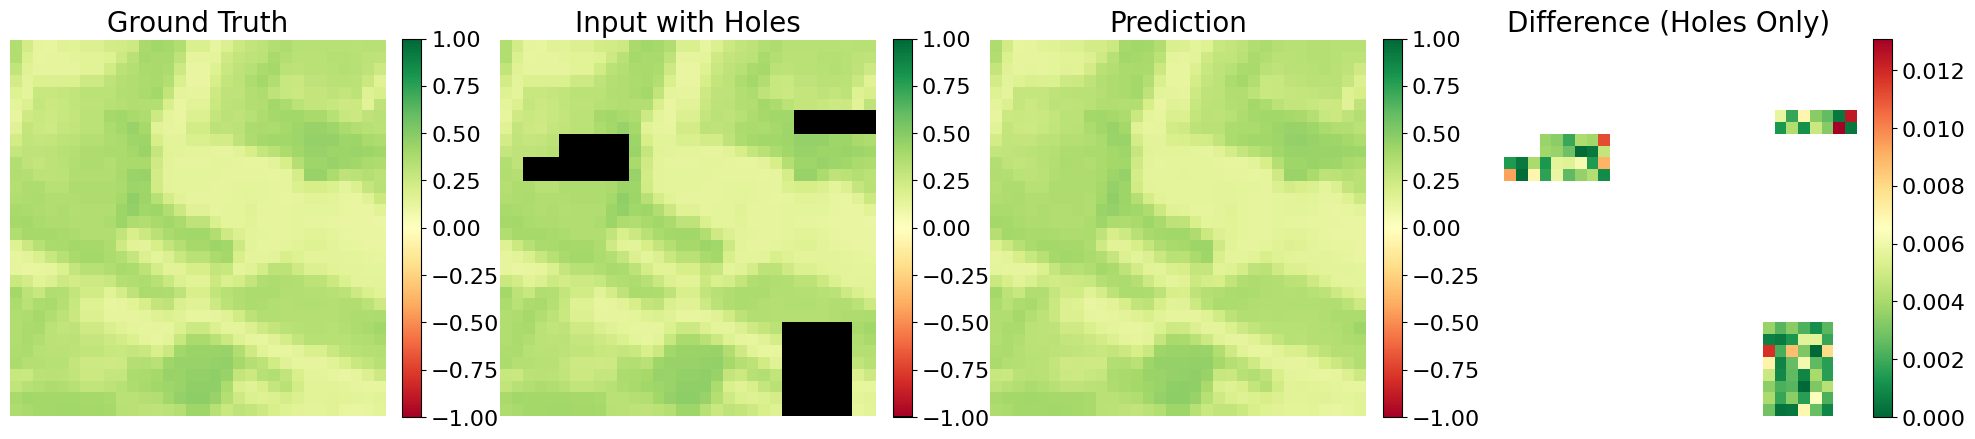

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, ListedColormap

# Création d'une colormap personnalisée pour les trous (valeurs spéciales = 10)
cmap = plt.cm.RdYlGn  # Colormap de base
cmap_colors = cmap(np.linspace(0, 1, 256))
cmap_colors[0] = [0, 0, 0, 1]  # Noir pour les trous (valeurs à 10)
custom_cmap = ListedColormap(cmap_colors)

# Normalisation personnalisée
class CustomNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, special_value=None, **kwargs):
        super().__init__(vmin=vmin, vmax=vmax, **kwargs)
        self.special_value = special_value

    def __call__(self, value, clip=None):
        # Traite les trous comme une valeur spéciale
        result = super().__call__(value, clip)
        result = np.ma.masked_where(value == self.special_value, result)
        result = np.ma.filled(result, 0)  # Mappe les trous (valeurs à 10) sur la première couleur (noir)
        return result

# Appliquer la normalisation personnalisée pour gérer les trous
norm = CustomNormalize(vmin=-1, vmax=1, special_value=10)

# Calcul de la différence entre l'image prédite et l'image originale
difference = np.abs(X_test - y_pred.squeeze())  # Différence absolue

# Créer un masque pour afficher uniquement les trous
mask_holes = (y_test == 10)  # Masque des pixels troués
difference_holes_only = np.where(mask_holes, difference, np.nan)  # Masque les autres pixels

# Visualisation des résultats
idx = 10  # Index pour visualiser un échantillon spécifique

plt.figure(figsize=(20, 5))

# Vérité terrain
plt.subplot(1, 4, 1)
plt.title("Ground Truth", fontsize=20)  # Increase font size
img1 = plt.imshow(X_test[idx, :, :], cmap='RdYlGn', norm=norm)
plt.axis('off')
cbar1 = plt.colorbar(img1, fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=16)  # Increase colorbar font size

# Image d'entrée avec trous
plt.subplot(1, 4, 2)
plt.title("Input with Holes", fontsize=20)  # Increase font size
img2 = plt.imshow(y_test[idx, :, :], cmap=custom_cmap, norm=norm)
plt.axis('off')
cbar2 = plt.colorbar(img2, fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=16)  # Increase colorbar font size

# Prédictions
plt.subplot(1, 4, 3)
plt.title("Prediction", fontsize=20)  # Increase font size
img3 = plt.imshow(y_pred[idx, :, :], cmap='RdYlGn', norm=norm)
plt.axis('off')
cbar3 = plt.colorbar(img3, fraction=0.046, pad=0.04)
cbar3.ax.tick_params(labelsize=16)  # Increase colorbar font size

# Différence uniquement dans les trous
plt.subplot(1, 4, 4)
plt.title("Difference (Holes Only)", fontsize=20)  # Increase font size
img4 = plt.imshow(difference_holes_only[idx, :, :], cmap='RdYlGn_r', vmin=0)  # Colormap pour différences
plt.axis('off')
cbar4 = plt.colorbar(img4, fraction=0.046, pad=0.04)
cbar4.ax.tick_params(labelsize=16)  # Increase colorbar font size

plt.tight_layout()
plt.show()


#### 4. Other

In [ ]:
# Load the model
from tensorflow.keras.models import load_model
from google.colab import drive
drive.mount('/content/drive')

model_path = '/content/drive/My Drive/NDVI_Landsat8_10/best_unet_model.keras'
model = load_model(model_path, custom_objects={'masked_mae': masked_mae})

# Print the model architecture
model.summary()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 1)           │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 998,597 (3.81 MB)

 Trainable params: 332,865 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 665,732 (2.54 MB)

In [ ]:
!apt-get install graphviz
import pydot
import os

# Create the Graphviz object
graph = pydot.Dot(graph_type='digraph', rankdir='LR')  # 'LR' for Left to Right layout

# Define the layers and activations
layers = [
    ("Input", "Input Layer", None),
    ("Conv1", "Conv2D (64 filters, 3x3)", 'relu'),
    ("Conv2", "Conv2D (64 filters, 3x3)", 'relu'),
    ("Pool1", "MaxPooling2D (2x2)", None),
    ("Conv3", "Conv2D (128 filters, 3x3)", 'relu'),
    ("Conv4", "Conv2D (128 filters, 3x3)", 'relu'),
    ("UpSample", "UpSampling2D (2x2)", None),
    ("Conv5", "Conv2D (64 filters, 3x3)", 'relu'),
    ("Output", "Conv2D (1 filter, 1x1)", 'sigmoid')
]

# Create nodes for the layers
for layer, label, activation in layers:
    label_text = f"{label}\nActivation: {activation}" if activation else label
    graph.add_node(pydot.Node(layer, label=label_text))

# Add edges (connections) between layers
graph.add_edge(pydot.Edge("Input", "Conv1"))
graph.add_edge(pydot.Edge("Conv1", "Conv2"))
graph.add_edge(pydot.Edge("Conv2", "Pool1"))
graph.add_edge(pydot.Edge("Pool1", "Conv3"))
graph.add_edge(pydot.Edge("Conv3", "Conv4"))
graph.add_edge(pydot.Edge("Conv4", "UpSample"))
graph.add_edge(pydot.Edge("UpSample", "Conv5"))
graph.add_edge(pydot.Edge("Conv5", "Output"))

# Create subgraphs to place layers in two columns
# Removed the 'with' statement and directly created the subgraphs
subgraph1 = pydot.Subgraph(rank='same')  # This makes the layers appear on the same level
subgraph1.add_node(pydot.Node("Conv1"))
subgraph1.add_node(pydot.Node("Conv2"))
subgraph1.add_node(pydot.Node("Pool1"))
subgraph1.add_node(pydot.Node("Conv3"))

graph.add_subgraph(subgraph1)

subgraph2 = pydot.Subgraph(rank='same')  # This makes the layers appear on the same level
subgraph2.add_node(pydot.Node("Conv4"))
subgraph2.add_node(pydot.Node("UpSample"))
subgraph2.add_node(pydot.Node("Conv5"))
subgraph2.add_node(pydot.Node("Output"))
graph.add_subgraph(subgraph2)

# Render the diagram
# Set the path to the Graphviz executables
os.environ["PATH"] += os.pathsep + '/usr/bin/dot'

# Use graph.write instead of graph.render
graph.write_png('/content/drive/My Drive/NDVI_Landsat8_10/cnn_with_activations_two_columns.png')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
